# Missing value processing for spot price

In [16]:
import pandas as pd
import ast
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

In [17]:
def GetSpotPrice(element_str):
    element = ast.literal_eval(element_str)
    timespans = element['TimeSpans']
    date = [datetime.strptime(element['Date'][:10]+' '+x['TimeSpan'][:5], \
        '%Y-%m-%d %H:%M') for x in timespans if x['TimeSpan']!='dst']
    value = [x['Value'] for x in timespans if x['TimeSpan']!='dst']
    data_per_day = pd.DataFrame(data={'date':date, 'value': value})
    return data_per_day

def ConcatNewLabel():
    old_data = pd.read_csv('Original_Data/spotprices_2011_2021.csv')
    old_label = list(map(GetSpotPrice, old_data['Elements']))
    old_label = pd.concat(old_label)

    new_data = pd.read_csv('Original_Data/spotprices_new.csv')
    new_data['date'] = [datetime.strptime(x, '%Y/%m/%d %H:%M') for x in new_data['date']]
    new_label = new_data[['date', 'value']][24:]

    label = pd.concat([old_label, new_label])
    return label


In [18]:
label = ConcatNewLabel()
label = label.set_index('date')
# get continuous timespan
label = label.asfreq(freq='h')
label[label['value'].isna()].index

DatetimeIndex(['2011-03-27 02:00:00', '2012-03-25 02:00:00',
               '2013-03-31 02:00:00', '2014-03-30 02:00:00',
               '2015-03-29 02:00:00', '2016-03-27 02:00:00',
               '2017-03-26 02:00:00', '2018-03-25 02:00:00',
               '2019-03-31 02:00:00', '2020-03-29 02:00:00',
               '2021-03-28 00:00:00', '2021-03-28 01:00:00',
               '2021-03-28 02:00:00', '2021-03-28 03:00:00',
               '2021-03-28 04:00:00', '2021-03-28 05:00:00',
               '2021-03-28 06:00:00', '2021-03-28 07:00:00',
               '2021-03-28 08:00:00', '2021-03-28 09:00:00',
               '2021-03-28 10:00:00', '2021-03-28 11:00:00',
               '2021-03-28 12:00:00', '2021-03-28 13:00:00',
               '2021-03-28 14:00:00', '2021-03-28 15:00:00',
               '2021-03-28 16:00:00', '2021-03-28 17:00:00',
               '2021-03-28 18:00:00', '2021-03-28 19:00:00',
               '2021-03-28 20:00:00', '2021-03-28 21:00:00',
               '2021-03-

Here we can see from 2011 to 2020, there are missing values for 2:00 - 3:00 at the end of March each year, which may be the annual maintenance time. Then, assume that the missing values are likely to be similar with the previous values (one timestep before the missing value). Our strategy to deal with the missing values from 2011 to 2020 is using next observation to fill gap. But for year 2021, the values of the entire March 28th were missing, therefore, for that particular day, we need to fill the average spot price of the previous day or forecast the missing values based on historical data. 

## Filling missing time serie using ARIMA

In [19]:
# function for forecasting missing time series
def FillTimeSereisMissing(data):
    # get corresponding timeperiod
    data = data.loc['2021-03-01 00:00:00':'2021-3-31 23:00:00']
    # set train and test data
    train = data.loc['2021-03-01 00:00:00':'2021-3-27 23:00:00']
    test = data.loc['2021-03-28 00:00:00':'2021-3-28 23:00:00']
    # fit model
    model = ARIMA(train, order=(15,1,0))
    model_fit = model.fit()
    # forecast
    forecast = model_fit.forecast(steps=len(test))
    result = forecast

    # get complete time series for visualization
    forecast = pd.DataFrame({'date': test.index, 'value': forecast}).set_index('date')
    pre_date = test.index[0] - test.index[0].freq
    post_date = test.index[-1] + test.index[0].freq
    pre_forecast = pd.DataFrame({'date': pre_date, 'value': data.loc[pre_date]}).set_index('date')
    post_forecast = pd.DataFrame({'date': post_date, 'value': data.loc[post_date]}).set_index('date')
    forecast = pd.concat([pre_forecast,forecast,post_forecast])

    # plot
    matplotlib.rcParams['figure.figsize'] = [12, 5]
    fig, ax = plt.subplots(1, 1)
    data.loc['2021-03-23 00:00:00':'2021-3-31 23:00:00'].plot(ax=ax, style='-', label='train', lw=2, color='blue')
    forecast.plot(ax=ax, style='--', label='forecast', lw=2, color='limegreen')

    plt.legend(['Spot Price'])
    plt.title("Visualization of filling missing values")
    plt.xlabel('Date')
    plt.ylabel('Price (€)')
    plt.grid()
    return result

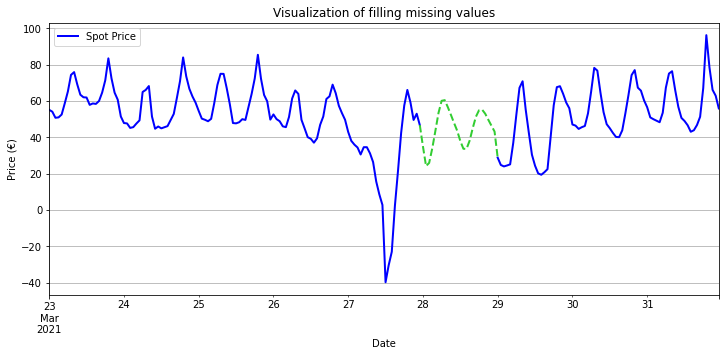

In [20]:
# getting the predicted missing values and visualization
missing_series = FillTimeSereisMissing(label)

Above figure shows the result of filling the missing values. We used ARIMA model to forecast the spot price on March 28th based on the historical price in March 2021. With order (15,1,0) for ARIMA, which means we carried out the differenced 15th-order autoregressive model， we can obtain quite good forecast for the missing values. 

In [21]:
# filling missing values
label.loc['2021-03-28 00:00:00':'2021-3-28 23:00:00'] = np.array(missing_series).reshape(24,1)

##  Filling single missing values using previous values

In [22]:
label[label['value'].isna()].index

DatetimeIndex(['2011-03-27 02:00:00', '2012-03-25 02:00:00',
               '2013-03-31 02:00:00', '2014-03-30 02:00:00',
               '2015-03-29 02:00:00', '2016-03-27 02:00:00',
               '2017-03-26 02:00:00', '2018-03-25 02:00:00',
               '2019-03-31 02:00:00', '2020-03-29 02:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

Now just single missing values are remained, which can be filled by the next valid observation.

In [23]:
# filling the gap using next valid observation
label = label.fillna(method='bfill')

In [24]:
label.loc['2011-03-27 00:00:00':'2011-03-27 04:00:00']

,value
date,
2011-03-27 00:00:00,48.08
2011-03-27 01:00:00,42.50
2011-03-27 02:00:00,40.09
2011-03-27 03:00:00,40.09
2011-03-27 04:00:00,43.10


In [25]:
# validation
label.isnull().sum()

value    0
dtype: int64

 Now, all missing values in label data are filled properly.

In [26]:
# save the processed label
label.index.freq = None
label.to_pickle('label.pkl')